# Módulo 30 - K-Means
**Atividade:**

Nesta tarefa, vamos explorar o algoritmo de clustering K-means aplicado a um contexto diferente do usual. Em vez de segmentar perfis de viajantes ou clientes de e-commerce, vamos usar dados biológicos para segmentar diferentes espécies de pinguins com base em características físicas. Esta abordagem destaca a versatilidade do K-means para diversas áreas além de vendas e marketing.

A base de dados utilizada é a penguins do pacote seaborn, que contém informações sobre três espécies de pinguins: Adelie, Chinstrap e Gentoo. As variáveis disponíveis incluem medições físicas dos pinguins coletadas na Antártica.

species: Espécie do pinguim (Adelie, Chinstrap, Gentoo)

island: Ilha onde o pinguim foi observado (Biscoe, Dream, Torgersen)

bill_length_mm: Comprimento do bico em milímetros

bill_depth_mm: Profundidade do bico em milímetros

flipper_length_mm: Comprimento da barbatana em milímetros

body_mass_g: Massa corporal em gramas

sex: Sexo do pinguim (Male, Female)

year: Ano em que a observação foi feita

In [42]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [29]:
penguins_original = sns.load_dataset('penguins')

In [30]:
penguins_original

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
3    Adelie  Torgersen             NaN            NaN                NaN   
4    Adelie  Torgersen            36.7           19.3              193.0   
..      ...        ...             ...            ...                ...   
339  Gentoo     Biscoe             NaN            NaN                NaN   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2         3250.0  Female  
3            NaN     NaN  
4         3450.0  Female  
..           ...     ...  
339          NaN     NaN  
340       4850.0  Female  
341       5750.0    Male  
342       5200.0  Female  
343       5400.0    Male  

[344 rows x 7 columns]

# 1 - Nesse exercício vocês devem verificar se temos variáveis missing, faltantes e excluir esses valores do dataset, também devem excluir as colunas com valores categóricos, que não utilizazam para o Kmeans.

Primeiro deve-se procurar e remover os registros que possuem valores inválidos  como NAN ou null.

In [31]:
penguins_original = penguins_original.dropna()
penguins_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


Com o dataset já limpo de registros inconsistentes, a próxima etapa é preparar as variáveis para aplicação do K-means. Como o algoritmo exige entradas numéricas, as colunas categóricas species, island e sex foram removidas da base utilizada no agrupamento.

Porém, considerando o contexto do dataset (espécies de pinguins) e o fato de que características morfológicas podem variar entre sexos, optou-se por construir duas bases adicionais, separando os registros em fêmeas e machos. Essa divisão foi realizada com o objetivo de comparar o desempenho do algoritmo entre os subconjuntos e avaliar se a variável sexo influencia a qualidade dos agrupamentos obtidos.

In [32]:
penguins = penguins_original
penguins = penguins.drop(['species', 'island'], axis=1)
penguins['sex'].value_counts()
penguins_femea = penguins[penguins['sex'] == 'Female']
penguins_macho = penguins[penguins['sex'] == 'Male']
penguins = penguins.drop(['sex'], axis=1)
penguins_macho = penguins_macho.drop(['sex'], axis=1)
penguins_femea = penguins_femea.drop(['sex'], axis=1)

# 2 - Visualize a análise descritiva dos seus dados utilizando a função vista em aula pairplot. É possível já identificar possíveis agrupamentos? Se sim, quantos?

Como o dataset foi subdividido em três conjuntos, penguins misto, penguins fêmea e penguins macho, a análise descritiva será realizada separadamente para cada uma das três bases.

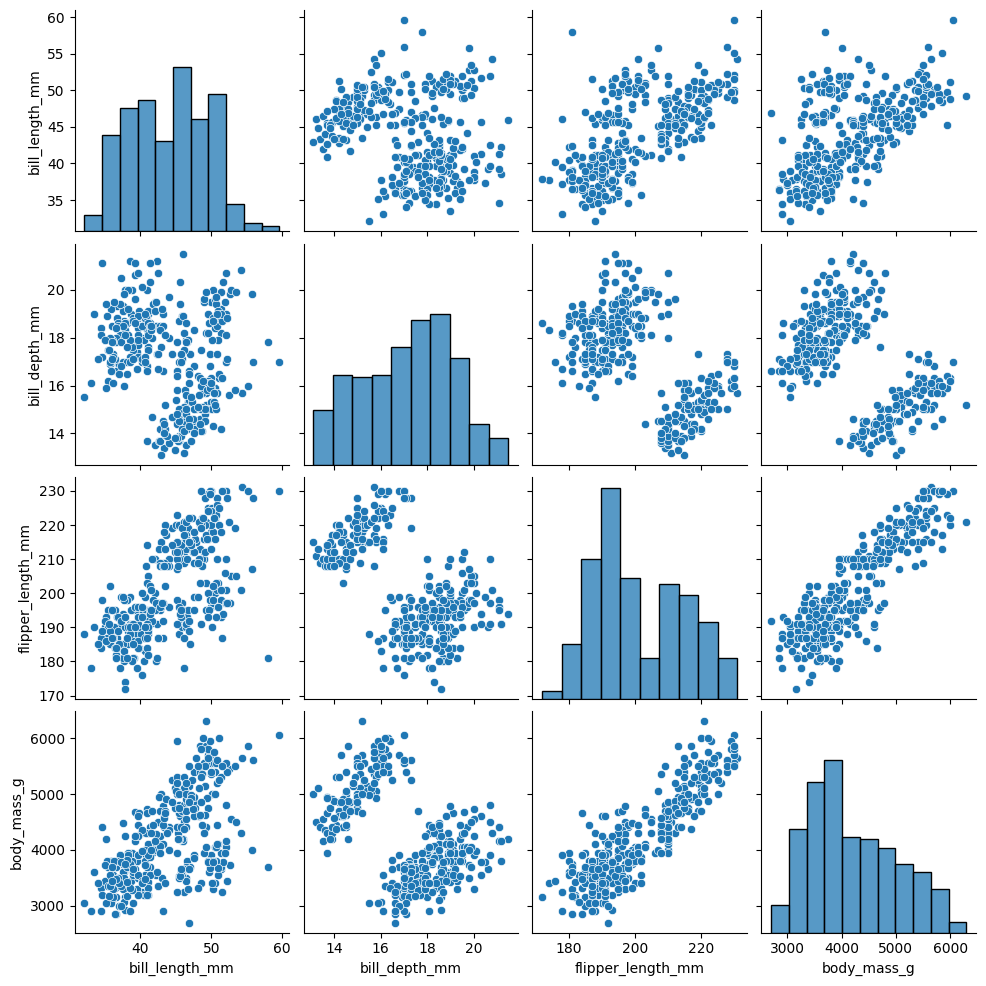

In [33]:
sns.pairplot(penguins)

Na maior parte dos gráficos gerados a partir da base mista, é possível identificar visualmente entre dois e três agrupamentos. No entanto, em alguns pares de variáveis a separação entre esses grupos não é bem definida, principalmente nas regiões de sobreposição. Esse comportamento fica evidente, por exemplo, na relação entre bill_length_mm e body_mass_g, em que há uma interseção considerável entre os pontos, dificultando a distinção clara dos grupos apenas pela inspeção visual.

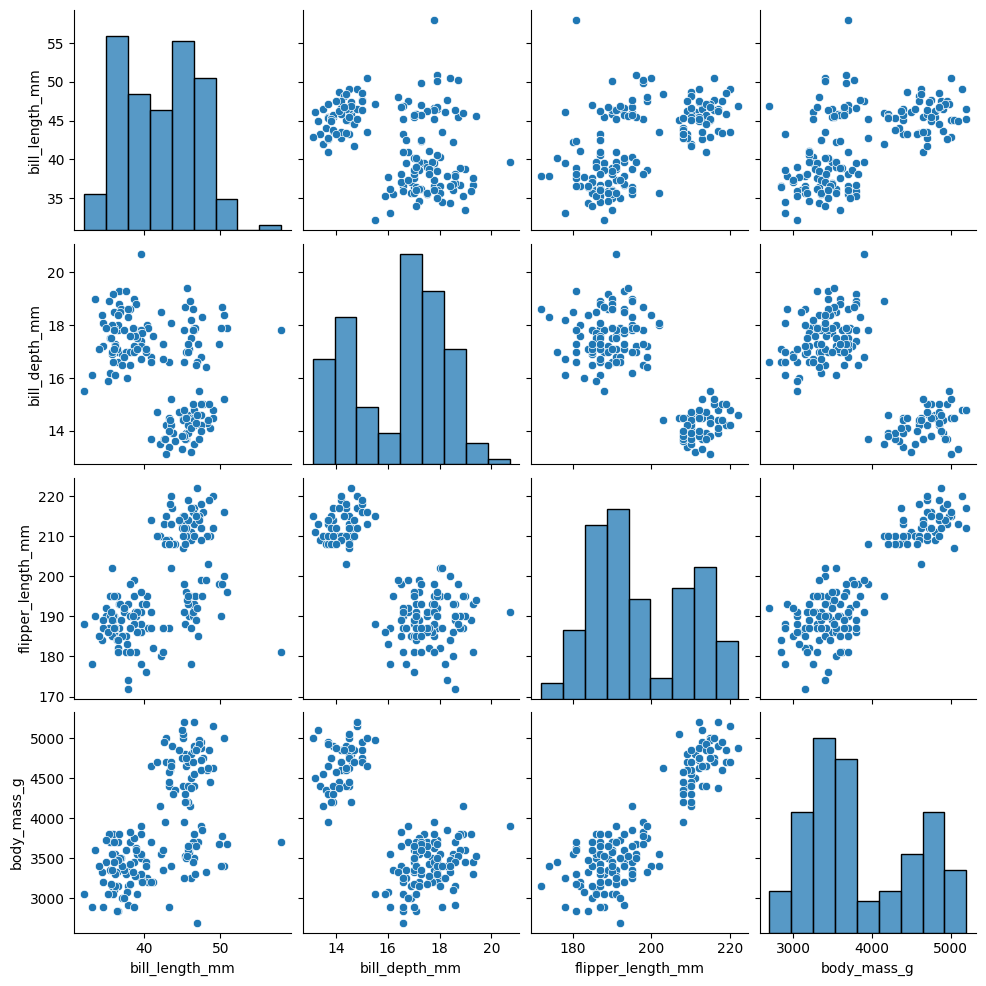

In [34]:
sns.pairplot(penguins_femea)

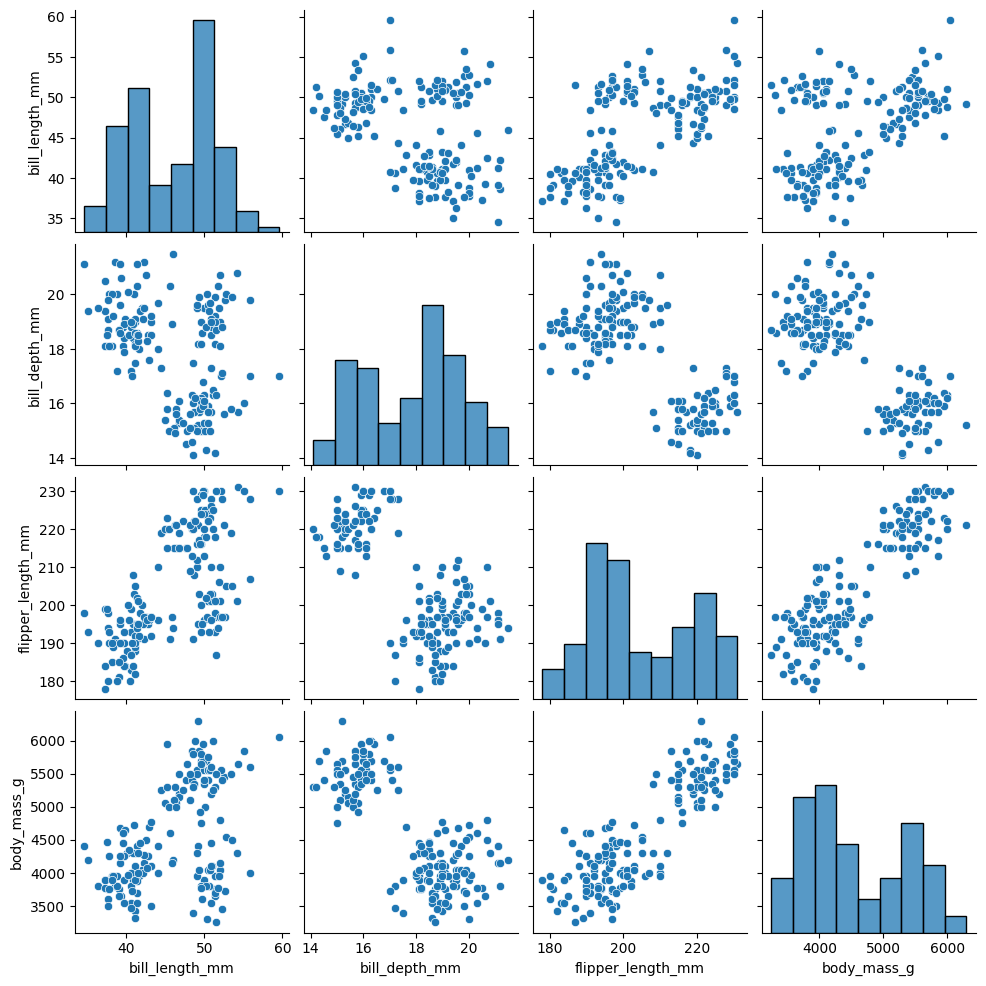

In [35]:
sns.pairplot(penguins_macho)

Para as bases de pinguins fêmea e macho, também é possível identificar visualmente entre dois e três grupos. No entanto, em comparação com a base mista, as regiões de interseção são menores, e a separação entre os agrupamentos tende a ser mais nítida, tornando a divisão dos grupos visualmente mais clara.

# 3 - Realize a padronização dos dados e visualize os dados.

Para iniciar a padronização dos dados, utilizou-se o StandardScaler, com o objetivo de normalizar o intervalo de variação entre as quatro variáveis, uma vez que havia diferenças significativas de escala entre algumas delas. Esse procedimento é importante para o K-means, pois o algoritmo é sensível à magnitude das variáveis e pode ser influenciado por atributos em escalas maiores. A padronização foi aplicada separadamente nas três bases criadas.

In [36]:
colunas = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
scaler = StandardScaler()
penguins_padronizado = scaler.fit_transform(penguins[colunas])
penguinsF_padronizado = scaler.fit_transform(penguins_femea[colunas])
penguinsM_padronizado = scaler.fit_transform(penguins_macho[colunas])

Em seguida, foram construídos gráficos de dispersão entre os pares de variáveis para observar o comportamento dos dados após a normalização, verificando como a padronização afetou a distribuição dos pontos e a separação visual entre possíveis agrupamentos.

In [37]:
penguins_datasets = {'misto' : penguins_padronizado, 'feminino':penguinsF_padronizado, 'Masculino':penguinsM_padronizado}

label = ['Tamanho do bico', 'Largura do bico', 'Tamanho da asa', 'Peso']

pares = [(0,1), (0,2), (0,3), (1,2), (2,3)]


for genero, data in penguins_datasets.items():
  fig = make_subplots(rows = 3, cols=2)
  for i in range(len(pares)):
    a, b = pares[i]

    row = (i//2) + 1
    cols = (i%2) + 1

    fig.add_trace(go.Scatter(x = data[:,a], y= data[:,b], mode='markers'), row = row, col = cols)
    fig.update_xaxes(title_text=label[a], row=row, col=cols)
    fig.update_yaxes(title_text=label[b], row=row, col=cols)

  fig.update_layout(title = f'Visualização dados Penguins gênero {genero}')
  fig.show()

Após a normalização, observa-se uma piora na visualização da separação dos grupos na base mista. Nesse caso, passam a aparecer dois agrupamentos mais evidentes, porém a fronteira entre eles se torna pouco definida, com uma região de transição que dificulta a distinção clara.

Em contraste, nas bases subdivididas por gênero, a região de interseção entre os grupos permanece menor e mais bem delimitada. Em alguns pares de variáveis, ainda é possível identificar visualmente dois a três agrupamentos, sugerindo uma estrutura de grupos mais consistente quando os dados são analisados separadamente por sexo.

# 4 - Aplique o algoritmo do k means escolhendo o numero de clusters como igual a 3, que é que a quantidade de espécies que temos na base.

Para a aplicação do algoritmo K-means, definiu-se k = 3, considerando que a base contém três espécies de pinguins. Além disso, foi utilizado o método de inicialização k-means++, com o objetivo de melhorar a escolha inicial dos centróides e favorecer uma convergência mais estável do algoritmo.

O K-means foi executado separadamente em cada uma das três bases. Em seguida, os modelos treinados foram armazenados na variável kmeans_models, e os rótulos (labels) atribuídos a cada amostra foram armazenados na variável kmeans_label.

In [38]:
kmeans_models = {}
kmeans_labels = {}

for genero, data in penguins_datasets.items():
  kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
  kmeans_labels[genero] = kmeans.fit_predict(data)
  kmeans_models[genero] = kmeans

# 5 - Construa pelo 2 matriz de dispersão como realizada em aula indicando os pontos e centroides.

**Comece usando x='bill_length_mm' e y='bill_depth_mm' para analisar o primeiro gráfico e em seguida escolha outras variaveis para o segundo.**

In [39]:
label = ['Tamanho do bico', 'Largura do bico', 'Tamanho da asa', 'Peso']
pares = [(0,1), (0,2), (0,3), (1,2), (2,3)]

for genero, data in penguins_datasets.items():

  kmeans_penguins = KMeans(n_clusters=3, init='k-means++', random_state=42)
  kmeans_penguins.fit(data)

  clusters = kmeans_penguins.labels_
  centroides = kmeans_penguins.cluster_centers_

  fig = make_subplots(rows = 3, cols=2)

  for i in range(len(pares)):
    a, b = pares[i]

    row = (i//2) + 1
    cols = (i%2) + 1

    fig.add_trace(go.Scatter(x = data[:,a], y= data[:,b], mode='markers', marker = dict(size = 6, color = clusters)), row = row, col = cols)
    fig.add_trace(go.Scatter(x = centroides[:,a], y= centroides[:,b], mode='markers', marker = dict(size = 14, symbol = 'x')), row = row, col = cols)

    fig.update_xaxes(title_text=label[a], row=row, col=cols)
    fig.update_yaxes(title_text=label[b], row=row, col=cols)

  fig.update_layout(title = f'Visualização dados Penguins gênero {genero}')
  fig.show()


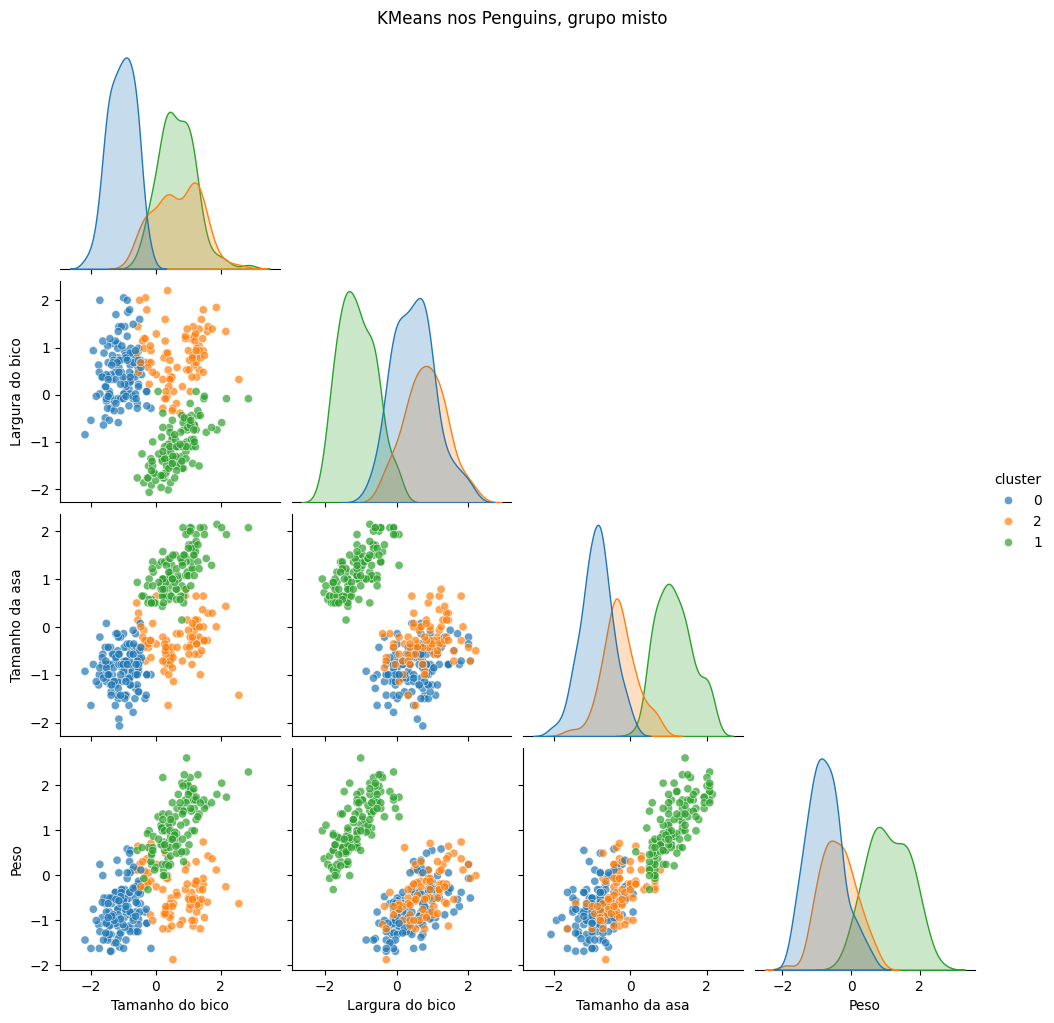

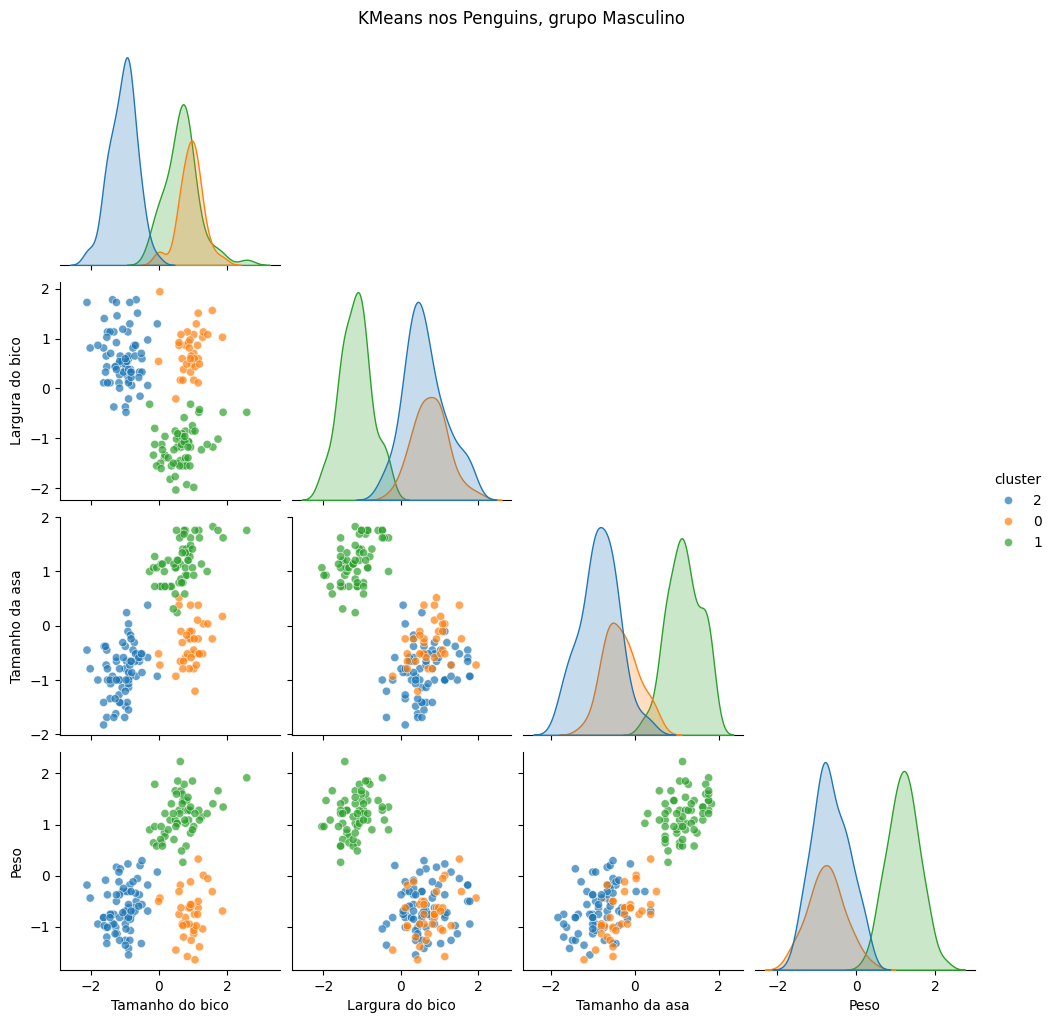

In [43]:
nomes_cols = ['Tamanho do bico', 'Largura do bico', 'Tamanho da asa', 'Peso']

for genero, data in penguins_datasets.items():
    df_plot = pd.DataFrame(data, columns=nomes_cols)
    df_plot['cluster'] = kmeans_labels[genero].astype(str)

    g = sns.pairplot(df_plot, vars=nomes_cols, hue='cluster', corner=True, plot_kws={'alpha': 0.7, 's': 35})

    g.fig.suptitle(f'KMeans nos Penguins, grupo {genero}', y=1.02)
    plt.show()

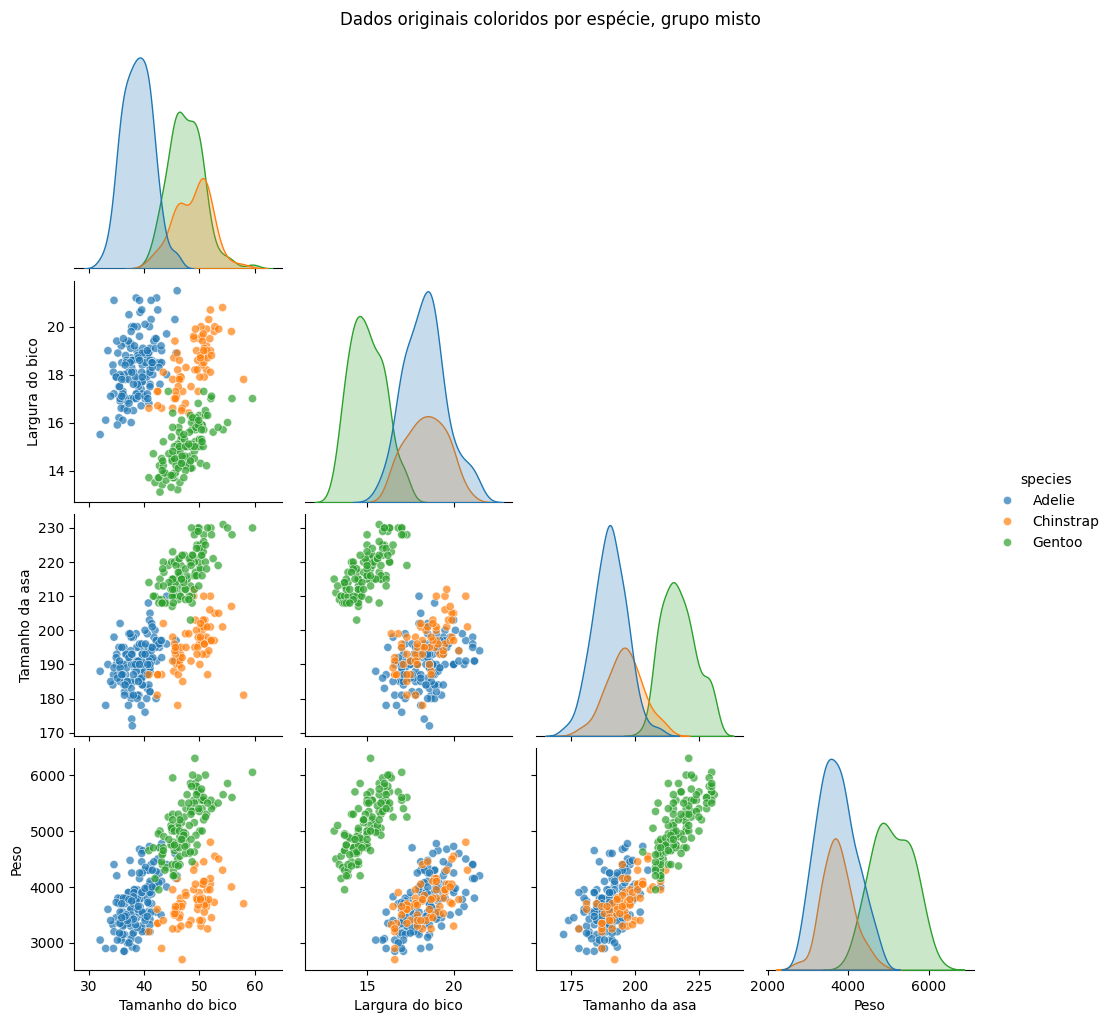

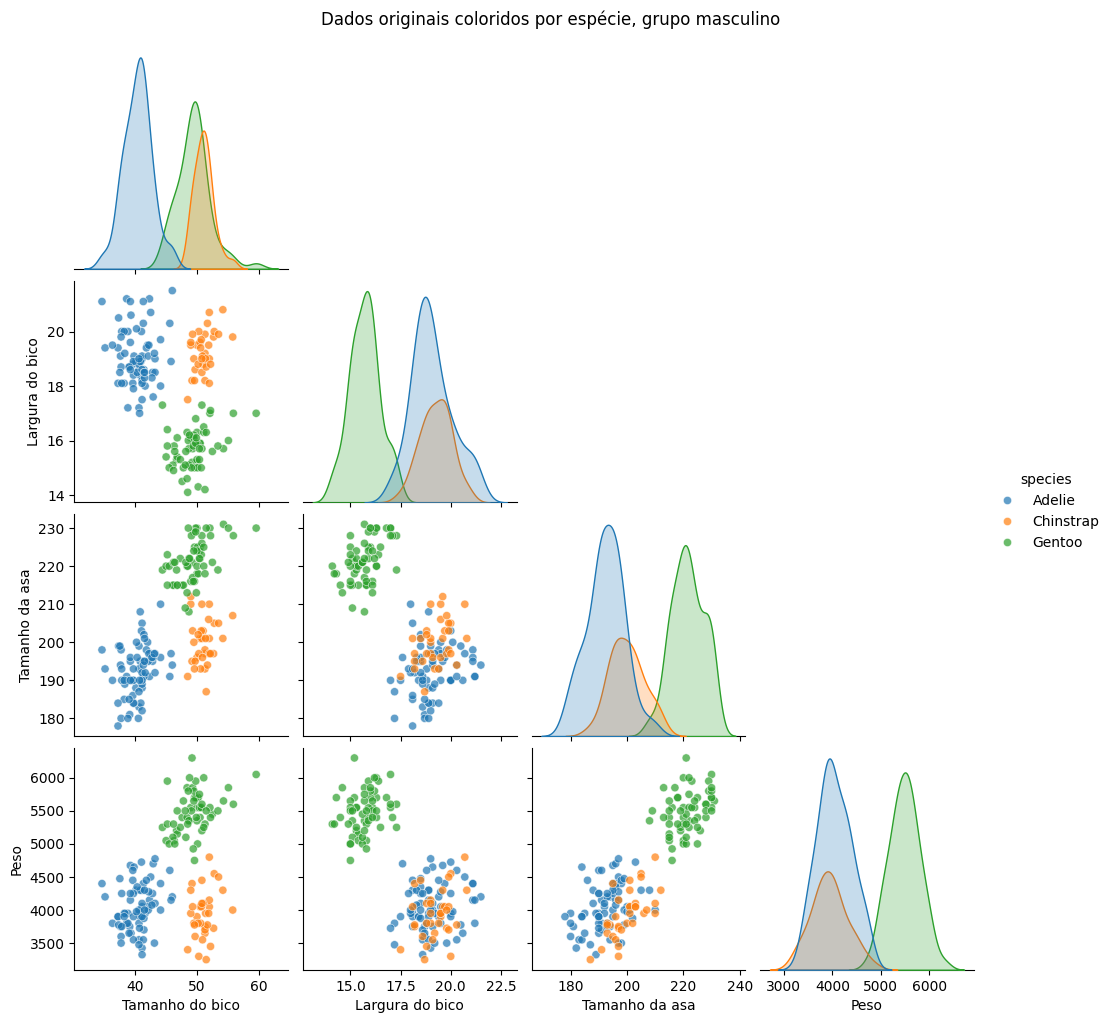

In [47]:
colunas = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']
rename_map = {'bill_length_mm':'Tamanho do bico','bill_depth_mm':'Largura do bico','flipper_length_mm':'Tamanho da asa','body_mass_g':'Peso'}
nomes_cols = ['Tamanho do bico','Largura do bico','Tamanho da asa','Peso']

base_misto = penguins_original[['species','sex']+colunas].copy().rename(columns=rename_map)
g = sns.pairplot(base_misto, vars=nomes_cols, hue='species', corner=True, plot_kws={'alpha':0.7,'s':35})
g.fig.suptitle('Dados originais coloridos por espécie, grupo misto', y=1.02)
plt.show()

base_f = penguins_original[penguins_original['sex']=='Female'][['species','sex']+colunas].copy().rename(columns=rename_map)
g = sns.pairplot(base_f, vars=nomes_cols, hue='species', corner=True, plot_kws={'alpha':0.7,'s':35})
g.fig.suptitle('Dados originais coloridos por espécie, grupo feminino', y=1.02)
plt.show()

base_m = penguins_original[penguins_original['sex']=='Male'][['species','sex']+colunas].copy().rename(columns=rename_map)
g = sns.pairplot(base_m, vars=nomes_cols, hue='species', corner=True, plot_kws={'alpha':0.7,'s':35})
g.fig.suptitle('Dados originais coloridos por espécie, grupo masculino', y=1.02)
plt.show()


image.png
image.png

Ao comparar os resultados obtidos pelo KMeans para o grupo misto com os rótulos reais de espécie da base de dados, observa-se que, apesar de o algoritmo ter feito um bom trabalho ao identificar padrões gerais, existe uma diferença evidente na distribuição dos grupos. Em especial, os clusters gerados pelo KMeans tendem a “englobar” mais pontos do que os grupos reais, formando agrupamentos um pouco maiores e com regiões de transição mais largas.

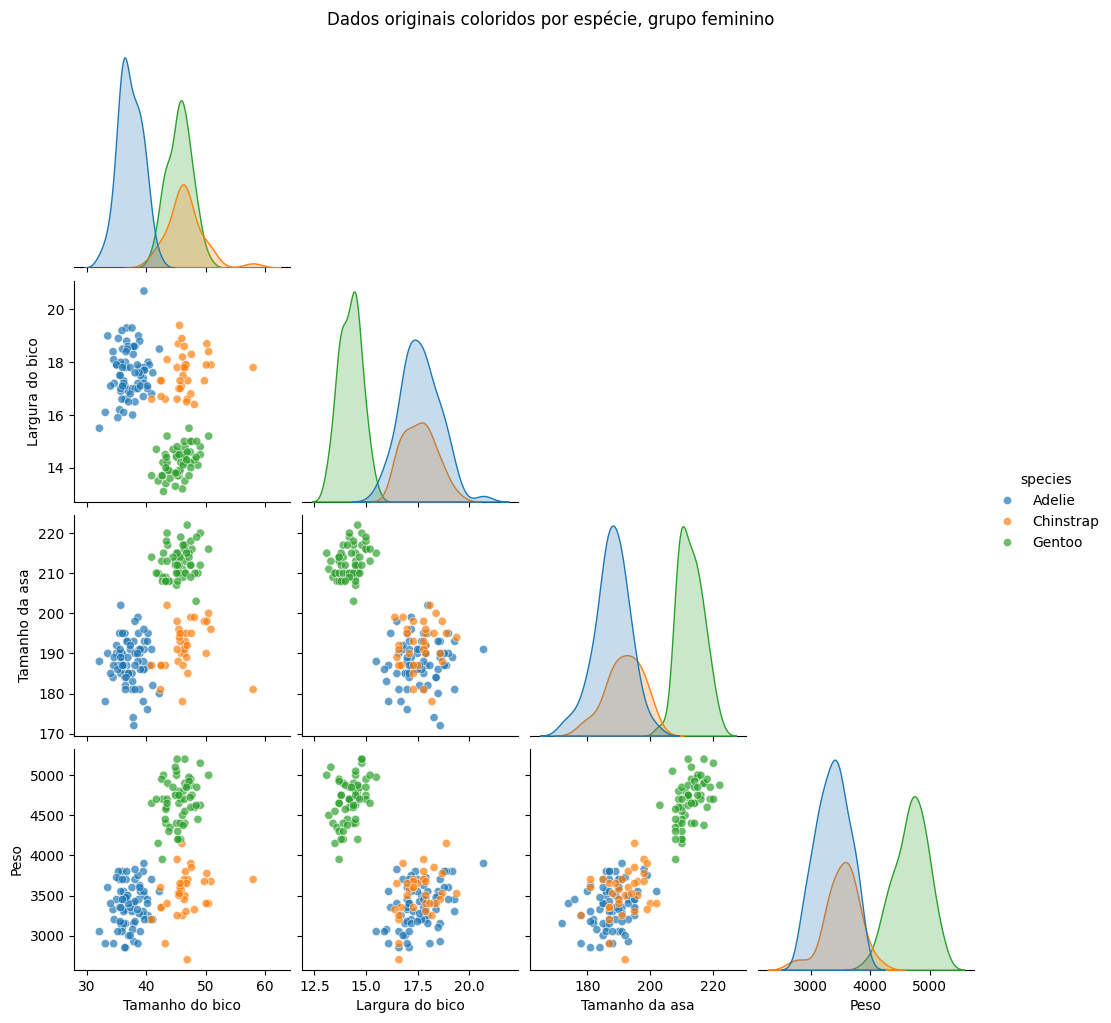
image.png

Quando se compara o resultado obtido pelo KMeans no subgrupo de fêmeas, percebe-se uma melhora expressiva na qualidade do agrupamento, com clusters visualmente muito próximos dos rótulos originais de espécie.

image.png
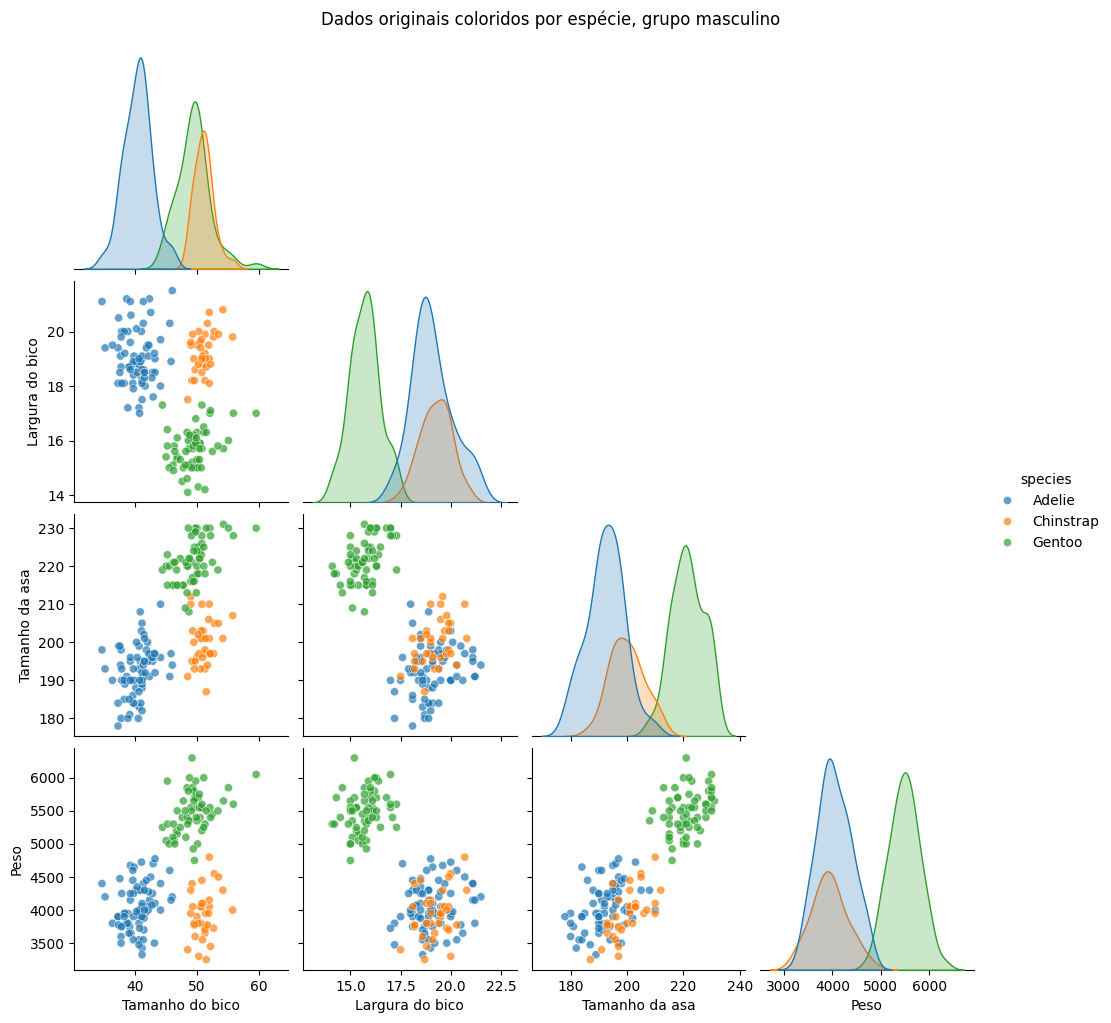

O mesmo padrão é observado no subgrupo de machos. Os clusters produzidos pelo KMeans também se aproximam mais dos grupos reais, com separações mais consistentes nas projeções entre pares de variáveis. Isso indica que o algoritmo teve maior facilidade em detectar os padrões associados às espécies quando a base foi previamente segmentada por sexo, pois essa segmentação diminui a variação que não está diretamente relacionada à espécie.

# 6 - Pesquise mais 3 utilidades de aplicações de algoritmos de clusterização e cite abaixo:

A clusterização pode ser aplicada como uma ferramenta prática para encontrar padrões em bases sem rótulo e transformar esses padrões em ações. Na saúde, por exemplo, é possível agrupar pacientes a partir de exames laboratoriais e sinais vitais como pressão arterial, IMC, glicemia, hemoglobina glicada e perfil lipídico para identificar perfis clínicos recorrentes. Com isso, surgem grupos com níveis de risco semelhantes, o que ajuda a priorizar acompanhamento e ações de prevenção, como intensificar monitoramento em clusters com maior risco cardiometabólico e direcionar intervenções mais simples para grupos com parâmetros controlados.

Já em pesquisa científica, a clusterização permite agrupar amostras por características experimentais e observar se aparecem subgrupos inesperados em dados que, a princípio, seriam homogêneos. Ao organizar amostras por padrões de resposta, marcadores biológicos ou perfis imunológicos, o algoritmo pode revelar estruturas escondidas que se tornam hipóteses de trabalho, como a existência de subtipos biológicos, respostas distintas a tratamentos ou potenciais biomarcadores que diferenciam grupos.

Por fim, podemos ver aplicação da clusterização em detecção de fraude, onde é usada para mapear padrões típicos de comportamento em transações, considerando variáveis como valor, frequência, horário e localização. A partir dos clusters que representam comportamentos normais, transações muito distantes ou difíceis de encaixar nos agrupamentos podem ser tratadas como anomalias e gerar alertas para investigação, aumentando a eficiência na detecção de irregularidades e reduzindo esforço manual.